In [1]:
import numpy as np
import pandas as pd
import xarray as xr
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import roc_auc_score
import os
base_dir = f'/mnt/lustre/koa/class/atmo449_class/students/team_1_flood_risk/'

In [2]:
station_id = 16240500# manoa
df_obs = pd.read_csv(f"{base_dir}/preprocessed_data/selected_flowgauge_3hourly/max/{station_id}.csv")
df_obs['hst_timestamp'] = pd.to_datetime(df_obs['hst_timestamp'])
df_obs.index = df_obs['hst_timestamp']#.dt.tz_localize('UTC')
df_obs = df_obs.drop(columns=['hst_timestamp'])

In [3]:
df_obs

,measurement
hst_timestamp,
2008-01-01 00:00:00-10:00,0.5075
2008-01-01 03:00:00-10:00,0.4850
2008-01-01 06:00:00-10:00,0.4775
2008-01-01 09:00:00-10:00,0.4600
2008-01-01 12:00:00-10:00,0.4500
...,...
2024-12-30 09:00:00-10:00,0.2575
2024-12-30 12:00:00-10:00,0.2500
2024-12-30 15:00:00-10:00,0.2500


In [165]:
df_daily = df_obs.resample('1d').max()
df_daily['exceedance'] = df_daily['measurement'] > np.percentile(df_daily.dropna()['measurement'], q=99)

In [184]:
all_year_data = []
for year in tqdm(range(2008, 2025)):
    all_year_data.append(xr.open_dataset(f"{base_dir}/preprocessed_data/regridded_3hourly_ERA5/{year}.nc")['tp'])
concatenated = xr.concat(all_year_data, dim='time')#.to_netcdf(f"{base_dir}/preprocessed_data/station_ERA5/{row.station_id}.nc")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:03<00:00,  5.52it/s]


In [215]:
df_daily.query('exceedance == True').index

DatetimeIndex(['2008-02-06 00:00:00-10:00', '2008-11-22 00:00:00-10:00',
               '2008-12-11 00:00:00-10:00', '2009-08-12 00:00:00-10:00',
               '2009-11-25 00:00:00-10:00', '2010-11-06 00:00:00-10:00',
               '2010-12-19 00:00:00-10:00', '2011-12-12 00:00:00-10:00',
               '2011-12-13 00:00:00-10:00', '2013-01-03 00:00:00-10:00',
               '2013-05-28 00:00:00-10:00', '2013-08-10 00:00:00-10:00',
               '2013-11-09 00:00:00-10:00', '2013-11-10 00:00:00-10:00',
               '2014-05-12 00:00:00-10:00', '2014-07-20 00:00:00-10:00',
               '2014-12-22 00:00:00-10:00', '2015-08-24 00:00:00-10:00',
               '2015-08-26 00:00:00-10:00', '2015-09-11 00:00:00-10:00',
               '2015-09-14 00:00:00-10:00', '2015-09-15 00:00:00-10:00',
               '2015-11-25 00:00:00-10:00', '2016-07-24 00:00:00-10:00',
               '2016-09-13 00:00:00-10:00', '2016-09-14 00:00:00-10:00',
               '2016-11-21 00:00:00-10:00', '2017-0

In [213]:
concatenated

<xarray.DataArray 'tp' (time: 49697, lat: 80, lon: 48)> Size: 763MB
array([[[4.57824535e-06, 1.43048112e-06, 7.34326341e-06, ...,
         7.83668729e-05, 4.98049267e-05, 2.33882292e-05],
        [6.19879870e-07, 5.88897956e-06, 5.25705473e-05, ...,
         1.29699954e-04, 1.49963918e-04, 1.85605735e-04],
        [1.90742583e-07, 1.90734204e-06, 2.34610579e-05, ...,
         2.70854780e-05, 4.52062632e-05, 7.28644736e-05],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         1.54965292e-05, 1.74726199e-04, 1.03055628e-03],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         1.05402178e-05, 1.26128172e-04, 7.23231526e-04],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         1.76546155e-06, 8.95104458e-05, 4.63584991e-04]],

       [[2.70204873e-06, 2.02493393e-05, 5.53755272e-05, ...,
         4.58947943e-05, 1.88903159e-05, 1.08478462e-05],
        [5.57902786e-06, 4.01656180e-05, 6.55500335e-05, ...,
         1.11333233e-04, 8.58223648e-05, 8.64650137e-05],
        [2.38404780e-07, 8.34494676e-06, 2.68460808e-05, ...,
         2.71967710e-05, 2.55274153e-05, 3.66545246e-05],
...
        [3.44119617e-05, 2.50107969e-05, 2.58850068e-05, ...,
         1.24781593e-06, 3.97531714e-08, 5.55847457e-08],
        [1.82477288e-05, 1.04129176e-05, 9.72922317e-06, ...,
         2.06742598e-07, 0.00000000e+00, 4.92779122e-07],
        [3.81482141e-06, 2.88496744e-06, 2.37652080e-06, ...,
         1.43018406e-06, 0.00000000e+00, 2.19990561e-05]],

       [[5.00636929e-07, 1.84765986e-06, 4.20800779e-06, ...,
         1.23979271e-06, 1.88346542e-06, 2.94436495e-06],
        [8.55891813e-06, 7.34333980e-06, 4.02938122e-06, ...,
         5.24520033e-07, 7.60547573e-06, 1.87633668e-05],
        [3.43358010e-06, 7.15269323e-07, 2.38392044e-08, ...,
         1.66884490e-07, 8.20166679e-06, 1.87518563e-05],
        ...,
        [1.26845462e-05, 1.54033260e-05, 9.53781819e-06, ...,
         2.01841885e-05, 1.70520389e-06, 0.00000000e+00],
        [1.16580768e-05, 6.12774875e-06, 3.88645458e-06, ...,
         1.41360479e-05, 2.52696100e-06, 2.14538574e-07],
        [5.64945076e-05, 2.91024189e-05, 1.15863013e-05, ...,
         1.52814086e-04, 1.22007114e-04, 8.07249453e-05]]], dtype=float32)
Coordinates:
  * lon      (lon) float64 384B 189.1 189.7 190.3 190.9 ... 217.2 217.8 218.4
  * lat      (lat) float64 640B -4.75 -4.25 -3.75 -3.25 ... 33.75 34.25 34.75
  * time     (time) datetime64[ns] 398kB 2007-12-31T22:00:00 ... 2024-12-31T2...

In [207]:
len(list(set(concatenated.time.values))), len(concatenated.time.values)

(49681, 49697)

In [212]:
df_daily.index

DatetimeIndex(['2008-01-01 00:00:00-10:00', '2008-01-02 00:00:00-10:00',
               '2008-01-03 00:00:00-10:00', '2008-01-04 00:00:00-10:00',
               '2008-01-05 00:00:00-10:00', '2008-01-06 00:00:00-10:00',
               '2008-01-07 00:00:00-10:00', '2008-01-08 00:00:00-10:00',
               '2008-01-09 00:00:00-10:00', '2008-01-10 00:00:00-10:00',
               ...
               '2024-12-21 00:00:00-10:00', '2024-12-22 00:00:00-10:00',
               '2024-12-23 00:00:00-10:00', '2024-12-24 00:00:00-10:00',
               '2024-12-25 00:00:00-10:00', '2024-12-26 00:00:00-10:00',
               '2024-12-27 00:00:00-10:00', '2024-12-28 00:00:00-10:00',
               '2024-12-29 00:00:00-10:00', '2024-12-30 00:00:00-10:00'],
              dtype='datetime64[ns, UTC-10:00]', name='hst_timestamp', length=6209, freq='D')

In [210]:
concatenated.drop_duplicates(dim='time').sel(time=df_daily.query('exceedance == True').index)

KeyError: "not all values found in index 'time'"

In [ ]:
concatenated.sel(time=)

<xarray.DataArray 'tp' (time: 49697, lat: 80, lon: 48)> Size: 763MB
array([[[4.57824535e-06, 1.43048112e-06, 7.34326341e-06, ...,
         7.83668729e-05, 4.98049267e-05, 2.33882292e-05],
        [6.19879870e-07, 5.88897956e-06, 5.25705473e-05, ...,
         1.29699954e-04, 1.49963918e-04, 1.85605735e-04],
        [1.90742583e-07, 1.90734204e-06, 2.34610579e-05, ...,
         2.70854780e-05, 4.52062632e-05, 7.28644736e-05],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         1.54965292e-05, 1.74726199e-04, 1.03055628e-03],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         1.05402178e-05, 1.26128172e-04, 7.23231526e-04],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         1.76546155e-06, 8.95104458e-05, 4.63584991e-04]],

       [[2.70204873e-06, 2.02493393e-05, 5.53755272e-05, ...,
         4.58947943e-05, 1.88903159e-05, 1.08478462e-05],
        [5.57902786e-06, 4.01656180e-05, 6.55500335e-05, ...,
         1.11333233e-04, 8.58223648e-05, 8.64650137e-05],
        [2.38404780e-07, 8.34494676e-06, 2.68460808e-05, ...,
         2.71967710e-05, 2.55274153e-05, 3.66545246e-05],
...
        [3.44119617e-05, 2.50107969e-05, 2.58850068e-05, ...,
         1.24781593e-06, 3.97531714e-08, 5.55847457e-08],
        [1.82477288e-05, 1.04129176e-05, 9.72922317e-06, ...,
         2.06742598e-07, 0.00000000e+00, 4.92779122e-07],
        [3.81482141e-06, 2.88496744e-06, 2.37652080e-06, ...,
         1.43018406e-06, 0.00000000e+00, 2.19990561e-05]],

       [[5.00636929e-07, 1.84765986e-06, 4.20800779e-06, ...,
         1.23979271e-06, 1.88346542e-06, 2.94436495e-06],
        [8.55891813e-06, 7.34333980e-06, 4.02938122e-06, ...,
         5.24520033e-07, 7.60547573e-06, 1.87633668e-05],
        [3.43358010e-06, 7.15269323e-07, 2.38392044e-08, ...,
         1.66884490e-07, 8.20166679e-06, 1.87518563e-05],
        ...,
        [1.26845462e-05, 1.54033260e-05, 9.53781819e-06, ...,
         2.01841885e-05, 1.70520389e-06, 0.00000000e+00],
        [1.16580768e-05, 6.12774875e-06, 3.88645458e-06, ...,
         1.41360479e-05, 2.52696100e-06, 2.14538574e-07],
        [5.64945076e-05, 2.91024189e-05, 1.15863013e-05, ...,
         1.52814086e-04, 1.22007114e-04, 8.07249453e-05]]], dtype=float32)
Coordinates:
  * lon      (lon) float64 384B 189.1 189.7 190.3 190.9 ... 217.2 217.8 218.4
  * lat      (lat) float64 640B -4.75 -4.25 -3.75 -3.25 ... 33.75 34.25 34.75
  * time     (time) datetime64[ns] 398kB 2007-12-31T22:00:00 ... 2024-12-31T2...

In [ ]:
xr.open_dataset(f"{base_dir}/preprocessed_data/regridded_3hourly_ERA5/2008.nc")

<xarray.Dataset> Size: 45MB
Dimensions:  (time: 2929, lat: 80, lon: 48)
Coordinates:
  * lon      (lon) float64 384B 189.1 189.7 190.3 190.9 ... 217.2 217.8 218.4
  * lat      (lat) float64 640B -4.75 -4.25 -3.75 -3.25 ... 33.75 34.25 34.75
  * time     (time) datetime64[ns] 23kB 2007-12-31T22:00:00 ... 2008-12-31T22...
Data variables:
    tp       (time, lat, lon) float32 45MB ...
Attributes:
    regrid_method:  conservative

In [171]:
df_daily

,measurement,exceedance
hst_timestamp,,
2008-01-01 00:00:00-10:00,0.499167,False
2008-01-02 00:00:00-10:00,1.435000,False
2008-01-03 00:00:00-10:00,0.845833,False
2008-01-04 00:00:00-10:00,1.355833,False
2008-01-05 00:00:00-10:00,0.918333,False
...,...,...
2024-12-26 00:00:00-10:00,0.256944,False
2024-12-27 00:00:00-10:00,0.250000,False
2024-12-28 00:00:00-10:00,0.250278,False


In [170]:
# plt.plot(df_daily['exceedance'])

In [2]:
def era5_obs_correlation_regridded_3hourly(station_id, aggregation):
    # load observation
    df_obs = pd.read_csv(f"{base_dir}/preprocessed_data/selected_flowgauge_3hourly/{aggregation}/{station_id}.csv")
    df_obs['hst_timestamp'] = pd.to_datetime(df_obs['hst_timestamp'])
    df_obs.index = df_obs['hst_timestamp']#.dt.tz_localize('UTC')

    # load era5
    df_era5 = xr.open_dataset(f"{base_dir}/preprocessed_data/station_ERA5/{station_id}.nc").to_dataframe().drop(columns=['lat', 'lon'])
    df_era5.index = df_era5.index.tz_localize('UTC').tz_convert('HST')
    df_era5.index.names = ['hst_timestamp']
    df_ml = pd.merge(df_obs[['measurement']], df_era5, left_index=True, right_index=True)

    df_ml['tp'] = df_ml['tp'] * 3 * 1000
    df_daily = df_ml.resample('1d').aggregate({'measurement': 'max', 'tp': 'sum'})

    df_daily['measurement_extreme'] = df_daily['measurement'] > np.percentile(df_daily.dropna()['measurement'], q=98.5)
    df_daily['tp_extreme'] = df_daily['tp'] > np.percentile(df_daily.dropna()['tp'], q=98.5)
    df_monthly = df_daily[['measurement_extreme', 'tp_extreme']].resample('ME').sum()
    return np.corrcoef(df_monthly['measurement_extreme'], df_monthly['tp_extreme'])[0,1]

In [3]:
def era5_obs_correlation_original_grid_3hourly(station_id, aggregation):
    # load observation
    df_obs = pd.read_csv(f"{base_dir}/preprocessed_data/selected_flowgauge_3hourly/{aggregation}/{station_id}.csv")
    df_obs['hst_timestamp'] = pd.to_datetime(df_obs['hst_timestamp'])
    df_obs.index = df_obs['hst_timestamp']#.dt.tz_localize('UTC')

    # load era5
    df_era5 = xr.open_dataset(f"{base_dir}/preprocessed_data/misc/original_grid_3hourly_station_ERA5/{station_id}.nc").to_dataframe().drop(columns=['lat', 'lon'])
    df_era5.index = df_era5.index.tz_localize('UTC').tz_convert('HST')
    df_era5.index.names = ['hst_timestamp']
    df_ml = pd.merge(df_obs[['measurement']], df_era5, left_index=True, right_index=True)

    df_ml['tp'] = df_ml['tp'] * 3 * 1000
    df_daily = df_ml.resample('1d').aggregate({'measurement': 'max', 'tp': 'sum'})

    df_daily['measurement_extreme'] = df_daily['measurement'] > np.percentile(df_daily.dropna()['measurement'], q=98.5)
    df_daily['tp_extreme'] = df_daily['tp'] > np.percentile(df_daily.dropna()['tp'], q=98.5)
    df_monthly = df_daily[['measurement_extreme', 'tp_extreme']].resample('ME').sum()
    return np.corrcoef(df_monthly['measurement_extreme'], df_monthly['tp_extreme'])[0,1]

In [8]:
available_station_ids = [int(i.split('.')[0]) for i in os.listdir(f"{base_dir}/preprocessed_data/selected_flowgauge_15mins")]
for station_id in available_station_ids:
    r = era5_obs_correlation_regridded_3hourly(station_id, aggregation='max')
    # r = era5_obs_correlation_original_grid_3hourly(station_id, aggregation='max')
    print(f"{r:02f}")

0.339263
-0.025125
0.248827
0.057476
0.097834
0.239192
0.311928
0.374128
0.042399
0.315868
0.209978
0.300618
0.138328
0.131809
0.077535
0.293284
0.211624
0.002718
0.013104
0.134967
0.422314
0.183275
-0.007785
0.075813
0.244638
0.164318
0.269424
0.198256
0.094957
0.034532
0.114117
0.344416


In [9]:
available_station_ids = [int(i.split('.')[0]) for i in os.listdir(f"{base_dir}/preprocessed_data/selected_flowgauge_15mins")]
station_id = available_station_ids[0]

In [ ]:
df_era5 = xr.open_dataset(f"{base_dir}/preprocessed_data/station_ERA5/{station_id}.nc").to_dataframe().drop(columns=['lat', 'lon'])
df_era5.index = df_era5.index + pd.Timedelta(hours=2)# cheating
# df_era5.index = df_era5.index.tz_localize('UTC').tz_convert('HST')
# df_era5.index.names = ['hst_timestamp']
df_era5['tp'] = df_era5['tp'] * 3 * 1000

In [118]:
df_cmip = xr.open_dataset(f"{base_dir}/preprocessed_data/station_cmip_historical/{station_id}.nc").to_dataframe().drop(columns=['lat', 'lon'])
df_cmip.index = pd.date_range('1981-01-01', '2011-01-01', freq='3h', inclusive='left', tz=None)
df_cmip['tp'] = df_cmip['pr'] * 86400

In [128]:
df_merged = pd.merge(df_cmip[['pr']], df_era5, left_index=True, right_index=True).dropna()

In [138]:
df_daily = df_merged.resample('1d').sum()

In [139]:
# plt.plot(df_merged['pr'] > np.percentile(df_merged['pr'], q=98.5))
# plt.plot((df_merged['tp'] > np.percentile(df_merged['tp'], q=98.5)) + 0.5)

In [140]:
np.corrcoef(
    df_daily['pr'] > np.percentile(df_daily['pr'], q=98.5),
    df_daily['tp'] > np.percentile(df_daily['tp'], q=98.5)
)[0,1]

0.009323966125300507

In [ ]:
numeric = xr.coding.times.encode_cf_datetime(
    ds_cmip.time.to_index(),
    units='days since 0001-01-01',
    calendar='julian'
)

In [48]:
xr.coding.times.decode_cf_datetime(numeric[0], units='days since 0001-01-01', calendar='proleptic_gregorian')

array(['1981-01-16T01:30:00.000000000', '1981-01-16T04:30:00.000000000',
       '1981-01-16T07:30:00.000000000', ...,
       '2011-01-15T16:30:00.000000000', '2011-01-15T19:30:00.000000000',
       '2011-01-15T22:30:00.000000000'], dtype='datetime64[ns]')

DatetimeIndex(['1981-01-01 00:00:00', '1981-01-01 03:00:00',
               '1981-01-01 06:00:00', '1981-01-01 09:00:00',
               '1981-01-01 12:00:00', '1981-01-01 15:00:00',
               '1981-01-01 18:00:00', '1981-01-01 21:00:00',
               '1981-01-02 00:00:00', '1981-01-02 03:00:00',
               ...
               '2010-12-30 18:00:00', '2010-12-30 21:00:00',
               '2010-12-31 00:00:00', '2010-12-31 03:00:00',
               '2010-12-31 06:00:00', '2010-12-31 09:00:00',
               '2010-12-31 12:00:00', '2010-12-31 15:00:00',
               '2010-12-31 18:00:00', '2010-12-31 21:00:00'],
              dtype='datetime64[ns]', length=87656, freq='3h')

In [60]:
ds_cmip

<xarray.Dataset> Size: 1MB
Dimensions:  (time: 87656)
Coordinates:
    lat      float64 8B ...
    lon      float64 8B ...
  * time     (time) object 701kB 1981-01-01 01:30:00 ... 2010-12-31 22:30:00
Data variables:
    pr       (time) float64 701kB ...

In [461]:
available_station_ids = [int(i.split('.')[0]) for i in os.listdir(f"{base_dir}/preprocessed_data/selected_flowgauge_15mins")]
for station_id in available_station_ids:
    # r = era5_obs_correlation_regridded_3hourly(station_id)
    r = era5_obs_correlation_original_grid_3hourly(station_id)
    print(f"{r:02f}")

0.472482
0.262827
0.536306
0.517261
0.295836
0.496877
0.407044
0.523108
0.483835
0.488851
0.525189
0.465698
0.176986
0.376465
0.285126
0.364745
0.450015
0.262728
0.194504
0.039409
0.262343
0.339573
0.324914
0.119384
0.243519
0.413135
0.500207
0.474013
0.335100
0.033851
0.286490
0.234783


In [ ]:
available_station_ids = [int(i.split('.')[0]) for i in os.listdir(f"{base_dir}/preprocessed_data/selected_flowgauge_15mins")]
station_id = 16240500# manoa
# station_id = available_station_ids[2]# 0.319
# station_id = available_station_ids[7]#0.365
# station_id = available_station_ids[11]# 0.353
station_id = available_station_ids[31]# 0.367
aggregation = 'mean'

In [444]:
station_id

16304200

In [445]:
df_station_data = pd.read_csv(f"{base_dir}/raw_data/station_metadata.csv")
df_station_data.query('station_id == 16304200')

,station_id,station_name,island,longitude,latitude
75,16304200,Kaluanui Stream nr Punaluu,Oahu,-157.908056,21.586111


In [439]:
# load observation
df_obs = pd.read_csv(f"{base_dir}/preprocessed_data/selected_flowgauge_3hourly/{aggregation}/{station_id}.csv")
df_obs['hst_timestamp'] = pd.to_datetime(df_obs['hst_timestamp'])
df_obs.index = df_obs['hst_timestamp']#.dt.tz_localize('UTC')

# load era5
df_era5 = xr.open_dataset(f"{base_dir}/preprocessed_data/station_ERA5/{station_id}.nc").to_dataframe().drop(columns=['lat', 'lon'])
df_era5.index = df_era5.index.tz_localize('UTC').tz_convert('HST')
df_era5.index.names = ['hst_timestamp']

In [440]:
df_ml = pd.merge(df_obs[['measurement']], df_era5, left_index=True, right_index=True)
# df_ml.to_csv(f"{base_dir}/preprocessed_data/ml_datasets/{station_id}.csv")

In [441]:
df_ml['tp'] = df_ml['tp'] * 3 * 1000
df_daily = df_ml.resample('1d').aggregate({'measurement': 'max', 'tp': 'sum'})

In [442]:
df_daily['measurement_extreme'] = df_daily['measurement'] > np.percentile(df_daily.dropna()['measurement'], q=98.5)
df_daily['tp_extreme'] = df_daily['tp'] > np.percentile(df_daily.dropna()['tp'], q=98.5)
df_monthly = df_daily[['measurement_extreme', 'tp_extreme']].resample('ME').sum()
np.corrcoef(df_monthly['measurement_extreme'], df_monthly['tp_extreme'])[0,1]

0.36704415410333147

In [453]:
6210 * 0.015

93.14999999999999

In [452]:
df_daily.sum()

measurement            23736.337847
tp                     10176.247070
measurement_extreme       84.000000
tp_extreme                95.000000
dtype: float64

In [449]:
df_daily

,measurement,tp,measurement_extreme,tp_extreme
hst_timestamp,,,,
2008-01-01 00:00:00+00:00,5.488333,0.167688,False,False
2008-01-02 00:00:00+00:00,6.657778,0.002385,True,False
2008-01-03 00:00:00+00:00,5.600000,0.371544,False,False
2008-01-04 00:00:00+00:00,5.665000,0.923773,False,False
2008-01-05 00:00:00+00:00,5.158333,1.153685,False,False
...,...,...,...,...
2024-12-27 00:00:00+00:00,2.627778,0.288890,False,False
2024-12-28 00:00:00+00:00,2.628056,2.121690,False,False
2024-12-29 00:00:00+00:00,4.091111,0.506629,False,False


In [448]:
df_monthly.sum()

measurement_extreme    84
tp_extreme             95
dtype: int64

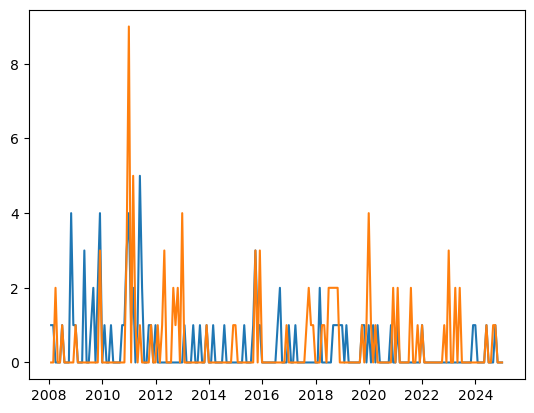

In [454]:
plt.plot(df_monthly['measurement_extreme'])
plt.plot(df_monthly['tp_extreme'])

In [189]:
np.corrcoef(df_yearly['measurement_extreme'], df_yearly['tp_extreme'])[0,1]

0.1240969544193744

In [163]:
np.percentile(df_daily.dropna()['measurement'], q=98), np.percentile(df_daily.dropna()['tp'], q=98)

(1.5610416666666667, 11.613324165344238)

In [172]:
np.corrcoef((df_daily['measurement'] > 1.56), (df_daily['tp'] > 15))[0,1]

0.005263668247424463

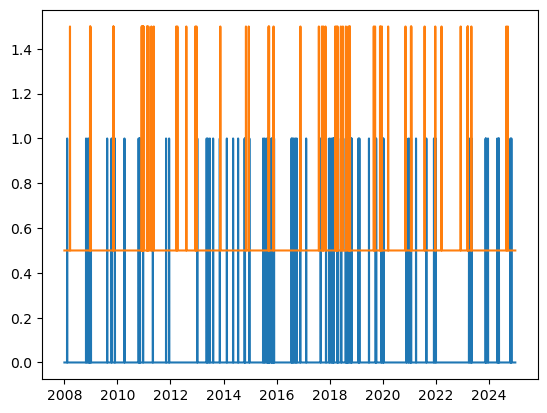

In [171]:
plt.plot((df_daily['measurement'] > 1.56))
plt.plot((df_daily['tp'] > 15) + 0.5)

In [103]:
# stats.pearsonr(df_ml.dropna()['tp'] > 0.0001, df_ml.dropna()['measurement'] > 3.1)

In [65]:
df_ml['tp-1'] = df_ml['tp'].shift(1)
df_ml['tp-2'] = df_ml['tp'].shift(2)
df_ml['accum'] = df_ml['tp'] + df_ml['tp-1']

In [66]:
df_ml = df_ml.dropna()

In [67]:
x_train = df_ml.iloc[:40000][['tp', 'tp-1', 'accum']].to_numpy()
y_train = df_ml.iloc[:40000]['measurement']# > 3.1

In [68]:
x_test = df_ml.iloc[40000:][['tp', 'tp-1', 'accum']].to_numpy()
y_test = df_ml.iloc[40000:]['measurement']# > 3.1

In [69]:
# model = MLPRegressor(hidden_layer_sizes=(8,8), activation='relu')
model = RandomForestRegressor()
# model = RandomForestClassifier()

In [70]:
model.fit(x_train, y_train)

RandomForestRegressor()

In [71]:
yhat = model.predict(x_test)

In [59]:
# roc_auc_score(y_test, yhat)

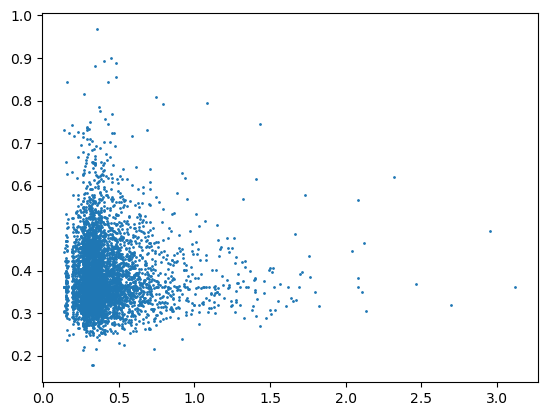

In [72]:
plt.scatter(y_test, yhat,s=1)

In [60]:
stats.pearsonr(df_ml.dropna()['accum'], df_ml.dropna()['measurement'])

PearsonRResult(statistic=0.2163383357856002, pvalue=0.0)

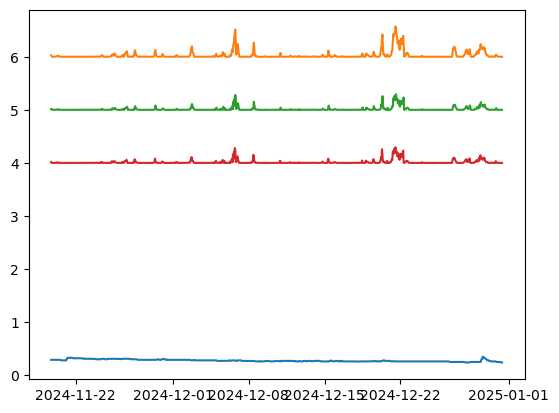

In [33]:
plt.plot(df_ml.iloc[-1000:]['measurement'])
plt.plot(df_ml.iloc[-1000:]['accum'] * 1000 + 6)
plt.plot(df_ml.iloc[-1000:]['tp-1'] * 1000 + 5)
plt.plot(df_ml.iloc[-1000:]['tp'] * 1000 + 4)

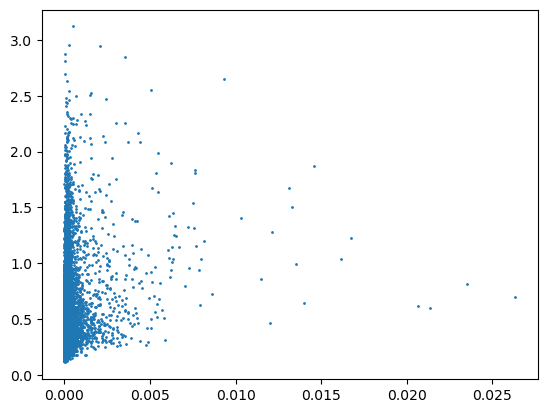

In [16]:
plt.scatter(df_ml['accum'], df_ml['measurement'], s=1)